# Student 2: Climate Text Analysis
## TF-IDF & BERT with LIME Interpretability

This notebook applies NLP methods to classify climate policy documents by sentiment.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk

from models import TextModelTrainer
from evaluation import ModelEvaluator, CrossValidationEvaluator
from interpretability import LIMETextInterpreter

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
print("Loading climate text dataset...")
df = pd.read_csv('../datasets/climate_news_text.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['sentiment'].value_counts())
df.head()

Loading climate text dataset...
Dataset shape: (9500, 13)

Target distribution:
sentiment
Negative    3325
Positive    3325
Neutral     2850
Name: count, dtype: int64


,document_id,publication_date,text,sentiment,source_type,urgency,impact_score,word_count,text_clean,text_length,char_count,avg_word_length,sentence_count
0,DOC_00001,2023-01-19,Controversy surrounds the proposed carbon capt...,Negative,Press_Release,High,2.58,41,controversy surrounds proposed carbon capture ...,29,323,7.878049,3
1,DOC_00002,2021-11-16,Annual report on energy production trends indi...,Neutral,Government_Report,Medium,3.23,42,annual report energy production trends indicat...,32,309,7.357143,4
2,DOC_00003,2024-03-30,Conference on clean air act brings together po...,Neutral,News_Article,Medium,2.52,43,conference clean air act brings together polic...,30,325,7.558140,4
3,DOC_00004,2024-02-08,Community-led initiatives in Finland demonstra...,Positive,Policy_Document,Low,4.68,42,community led initiatives finland demonstrate ...,35,361,8.595238,4
4,DOC_00005,2023-03-18,New regulations on transportation emissions ha...,Positive,Policy_Document,Low,3.91,44,new regulations transportation emissions succe...,31,330,7.500000,4


In [3]:
print("Sample texts by sentiment:\n")
for sentiment in df['sentiment'].unique():
    print(f"\n{sentiment.upper()}:")
    print(df[df['sentiment'] == sentiment]['text'].iloc[0][:300] + "...")

Sample texts by sentiment:


NEGATIVE:
Controversy surrounds the proposed carbon capture project as environmental groups raise concerns about ecological impact and long-term sustainability. The plan has faced significant opposition from local communities and scientists who question the effectiveness of the approach in achieving meaningfu...

NEUTRAL:
Annual report on energy production trends indicates modest changes in emission levels across Europe. While some countries show progress in reducing greenhouse gases, others struggle with industrial growth and energy demands. The data suggests varied approaches to environmental policy with differing ...

POSITIVE:
Community-led initiatives in Finland demonstrate remarkable success in reducing local pollution through grassroots environmental programs. Citizens have adopted hydrogen fuel cells practices and sustainable lifestyle changes, inspiring similar movements across Europe. Local authorities credit educat...


## 2. Data Preparation

In [4]:
X_text = df['text_clean'].copy()
y = df['sentiment'].copy()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Total samples: {len(X_text)}")
print(f"\nClass mapping:")
for idx, label in enumerate(le.classes_):
    print(f"  {idx}: {label}")

Total samples: 9500

Class mapping:
  0: Negative
  1: Neutral
  2: Positive


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_text, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")
print(f"\nClass distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 6650
Validation set: 1425
Test set: 1425

Class distribution in training:
  Negative: 2327 (35.0%)
  Neutral: 1995 (30.0%)
  Positive: 2328 (35.0%)


## 3. Method 1: TF-IDF + Logistic Regression

In [6]:
print("Creating TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✓ TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Training shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")

Creating TF-IDF vectorizer...
✓ TF-IDF features: 1223
Training shape: (6650, 1223)
Test shape: (1425, 1223)


In [7]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

lr_model.fit(X_train_tfidf, y_train)
print("✓ Logistic Regression training complete!")

y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)

print(f"\nTraining accuracy: {lr_model.score(X_train_tfidf, y_train):.4f}")
print(f"Test accuracy: {lr_model.score(X_test_tfidf, y_test):.4f}")

Training Logistic Regression...
✓ Logistic Regression training complete!

Training accuracy: 1.0000
Test accuracy: 1.0000


### TF-IDF + Logistic Regression Evaluation

In [8]:
evaluator_lr = ModelEvaluator(task_type='classification')
metrics_lr = evaluator_lr.evaluate_classification(y_test, y_pred_lr, y_pred_proba_lr, average='weighted')

print("="*60)
print("TF-IDF + LOGISTIC REGRESSION METRICS")
print("="*60)
print(f"Accuracy:           {metrics_lr['accuracy']:.4f}")
print(f"Precision (Weighted): {metrics_lr['precision']:.4f}")
print(f"Recall (Weighted):    {metrics_lr['recall']:.4f}")
print(f"F1-Score (Weighted):  {metrics_lr['f1_score']:.4f}")
print(f"Cohen's Kappa:       {metrics_lr['cohen_kappa']:.4f}")
print(f"Matthews Corr Coef:  {metrics_lr['matthews_corrcoef']:.4f}")
if 'auc_roc_ovr' in metrics_lr and metrics_lr['auc_roc_ovr'] is not None:
    print(f"AUC-ROC (OvR):       {metrics_lr['auc_roc_ovr']:.4f}")

TF-IDF + LOGISTIC REGRESSION METRICS
Accuracy:           1.0000
Precision (Weighted): 1.0000
Recall (Weighted):    1.0000
F1-Score (Weighted):  1.0000
Cohen's Kappa:       1.0000
Matthews Corr Coef:  1.0000
AUC-ROC (OvR):       1.0000


In [9]:
evaluator_lr.print_classification_report(y_test, y_pred_lr, target_names=le.classes_)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       499
     Neutral       1.00      1.00      1.00       428
    Positive       1.00      1.00      1.00       498

    accuracy                           1.00      1425
   macro avg       1.00      1.00      1.00      1425
weighted avg       1.00      1.00      1.00      1425



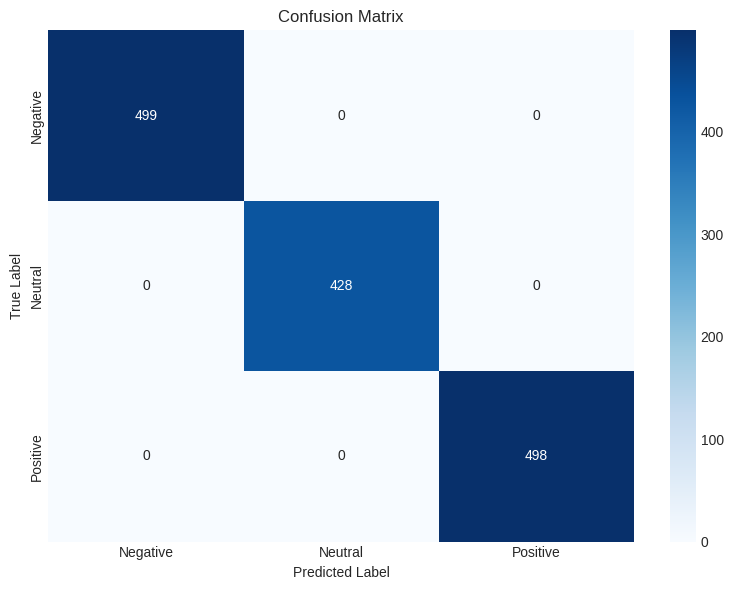

In [10]:
fig = evaluator_lr.plot_confusion_matrix(y_test, y_pred_lr, labels=le.classes_, figsize=(8, 6), normalize=False)
plt.savefig('../results/figures/lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Top Features per Sentiment

In [11]:
feature_names = vectorizer.get_feature_names_out()

for idx, sentiment in enumerate(le.classes_):
    coef = lr_model.coef_[idx]
    top_indices = np.argsort(coef)[-15:][::-1]
    print(f"\nTop 15 features for {sentiment.upper()}:")
    for i, feat_idx in enumerate(top_indices, 1):
        print(f"  {i}. {feature_names[feat_idx]}: {coef[feat_idx]:.4f}")


Top 15 features for NEGATIVE:
  1. climate: 1.5568
  2. health: 1.0396
  3. meaningful: 0.9086
  4. highlights: 0.9040
  5. action: 0.9040
  6. immediate: 0.8908
  7. calls: 0.8908
  8. meet: 0.5912
  9. meet carbon: 0.5912
  10. international climate: 0.5912
  11. insufficient: 0.5912
  12. despite: 0.5912
  13. undermine climate: 0.5912
  14. political: 0.5912
  15. undermine: 0.5912

Top 15 features for NEUTRAL:
  1. findings: 1.0448
  2. data: 1.0292
  3. costs: 1.0277
  4. relationship: 0.6713
  5. investigation needed: 0.6713
  6. team: 0.6713
  7. needed establish: 0.6713
  8. research team: 0.6713
  9. findings relationship: 0.6713
  10. publishes: 0.6713
  11. pollution patterns: 0.6713
  12. investigation: 0.6713
  13. relationships: 0.6713
  14. causal relationships: 0.6713
  15. insights pollution: 0.6713

Top 15 features for POSITIVE:
  1. includes: 1.0871
  2. solutions: 1.0502
  3. community: 1.0302
  4. practices: 0.9638
  5. positive: 0.9523
  6. new: 0.6934
  7. aime

## 4. Method 2: TF-IDF + SVM

In [12]:
print("Training SVM Classifier...")
svm_model = SVC(
    C=1.0,
    kernel='linear',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_tfidf, y_train)
print("✓ SVM training complete!")

y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)

print(f"\nTraining accuracy: {svm_model.score(X_train_tfidf, y_train):.4f}")
print(f"Test accuracy: {svm_model.score(X_test_tfidf, y_test):.4f}")

Training SVM Classifier...
✓ SVM training complete!

Training accuracy: 1.0000
Test accuracy: 1.0000


### SVM Evaluation

In [13]:
evaluator_svm = ModelEvaluator(task_type='classification')
metrics_svm = evaluator_svm.evaluate_classification(y_test, y_pred_svm, y_pred_proba_svm, average='weighted')

print("="*60)
print("TF-IDF + SVM METRICS")
print("="*60)
print(f"Accuracy:           {metrics_svm['accuracy']:.4f}")
print(f"Precision (Weighted): {metrics_svm['precision']:.4f}")
print(f"Recall (Weighted):    {metrics_svm['recall']:.4f}")
print(f"F1-Score (Weighted):  {metrics_svm['f1_score']:.4f}")
print(f"Cohen's Kappa:       {metrics_svm['cohen_kappa']:.4f}")
print(f"Matthews Corr Coef:  {metrics_svm['matthews_corrcoef']:.4f}")
if 'auc_roc_ovr' in metrics_svm and metrics_svm['auc_roc_ovr'] is not None:
    print(f"AUC-ROC (OvR):       {metrics_svm['auc_roc_ovr']:.4f}")

TF-IDF + SVM METRICS
Accuracy:           1.0000
Precision (Weighted): 1.0000
Recall (Weighted):    1.0000
F1-Score (Weighted):  1.0000
Cohen's Kappa:       1.0000
Matthews Corr Coef:  1.0000
AUC-ROC (OvR):       1.0000


In [14]:
evaluator_svm.print_classification_report(y_test, y_pred_svm, target_names=le.classes_)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       499
     Neutral       1.00      1.00      1.00       428
    Positive       1.00      1.00      1.00       498

    accuracy                           1.00      1425
   macro avg       1.00      1.00      1.00      1425
weighted avg       1.00      1.00      1.00      1425



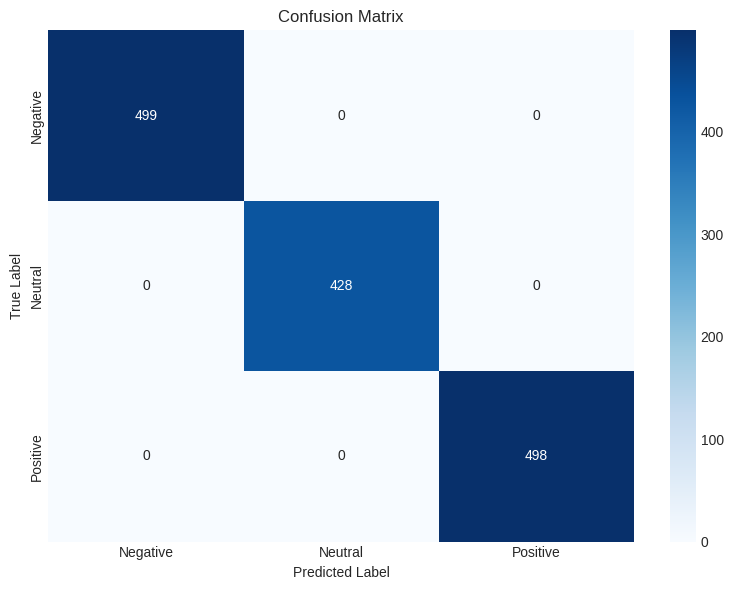

In [15]:
fig = evaluator_svm.plot_confusion_matrix(y_test, y_pred_svm, labels=le.classes_, figsize=(8, 6), normalize=False)
plt.savefig('../results/figures/svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Cross-Validation for Both Methods

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

print("Performing 5-fold CV for Logistic Regression...")
cv_results_lr = cross_validate(lr_model, X_train_tfidf, y_train, cv=cv, 
                               scoring=scoring, return_train_score=True, n_jobs=-1)

for metric in ['accuracy', 'f1_weighted']:
    scores = cv_results_lr[f'test_{metric}']
    print(f"\nLR {metric}: Mean={np.mean(scores):.4f}, Std={np.std(scores):.4f}")

print("\nPerforming 5-fold CV for SVM...")
cv_results_svm = cross_validate(svm_model, X_train_tfidf, y_train, cv=cv, 
                                scoring=scoring, return_train_score=True, n_jobs=-1)

for metric in ['accuracy', 'f1_weighted']:
    scores = cv_results_svm[f'test_{metric}']
    print(f"\nSVM {metric}: Mean={np.mean(scores):.4f}, Std={np.std(scores):.4f}")

Performing 5-fold CV for Logistic Regression...

LR accuracy: Mean=1.0000, Std=0.0000

LR f1_weighted: Mean=1.0000, Std=0.0000

Performing 5-fold CV for SVM...

SVM accuracy: Mean=1.0000, Std=0.0000

SVM f1_weighted: Mean=1.0000, Std=0.0000


## 5. Model Comparison

In [17]:
results_dict = {
    'Logistic_Regression': metrics_lr,
    'SVM': metrics_svm
}

comp_eval = ModelEvaluator(task_type='classification')
comparison_df = comp_eval.compare_models(results_dict)
print("\nModel Performance Comparison:")
print("="*60)
print(comparison_df)


Model Performance Comparison:
                    accuracy precision recall f1_score cohen_kappa
Logistic_Regression      1.0       1.0    1.0      1.0         1.0
SVM                      1.0       1.0    1.0      1.0         1.0


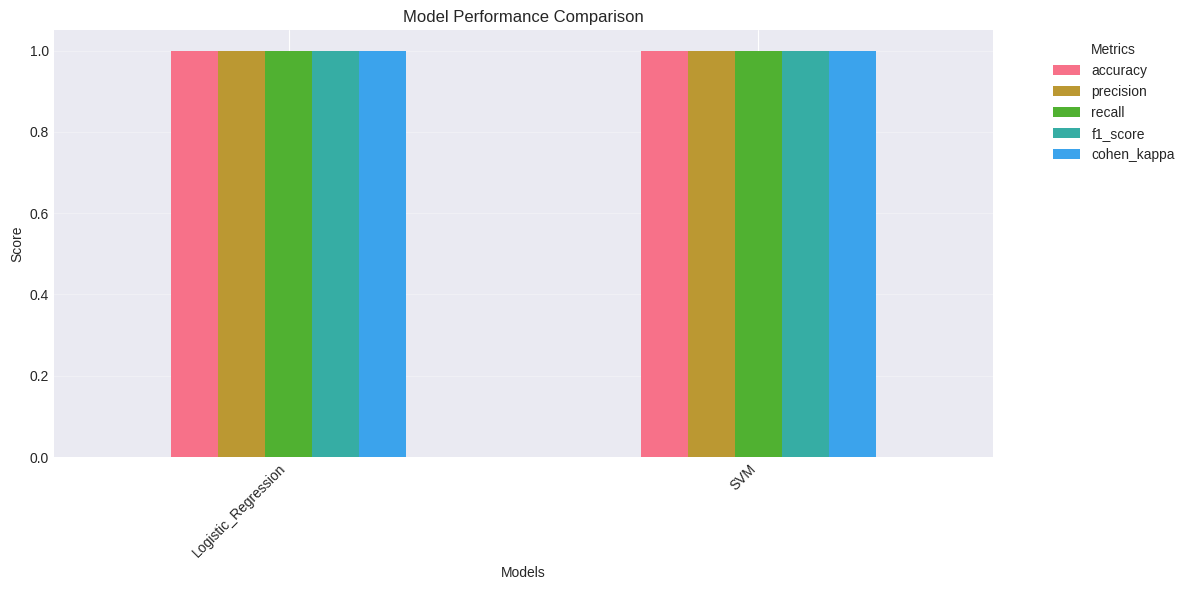

In [18]:
fig = comp_eval.plot_metrics_comparison(results_dict, 
                                        metrics_to_plot=['accuracy', 'precision', 'recall', 'f1_score', 'cohen_kappa'],
                                        figsize=(12, 6))
plt.savefig('../results/figures/student2_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. LIME Interpretability Analysis

### Initialize LIME Text Explainer

In [19]:
print("Initializing LIME Text Explainer...")
lime_explainer = LIMETextInterpreter(class_names=le.classes_.tolist())

def predict_fn(texts):
    tfidf_features = vectorizer.transform(texts)
    return lr_model.predict_proba(tfidf_features)

print("✓ LIME explainer initialized!")

Initializing LIME Text Explainer...
✓ LIME explainer initialized!


### Explain Sample Predictions

In [20]:
sample_idx = 10
sample_text = X_test.iloc[sample_idx]
true_label = le.classes_[y_test[sample_idx]]
pred_label = le.classes_[y_pred_lr[sample_idx]]

print(f"Sample Text (truncated):\n{sample_text[:300]}...\n")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")

exp = lime_explainer.explain_instance(sample_text, predict_fn, num_features=10, top_labels=1)

print("\nLIME Explanation:")
print(exp.as_list(label=y_pred_lr[sample_idx]))

Sample Text (truncated):
controversy surrounds proposed battery storage project environmental groups raise concerns ecological impact long term sustainability plan faced significant opposition local communities scientists question effectiveness approach achieving meaningful emissions reductions...

True Label: Negative
Predicted Label: Negative

LIME Explanation:
[('meaningful', 0.02973592416585631), ('plan', 0.02636986040305823), ('impact', 0.02621782692089277), ('long', 0.02554186706800351), ('groups', 0.025331703587579003), ('ecological', 0.024928476063068913), ('effectiveness', 0.024872965922729435), ('surrounds', 0.024564893794707922), ('storage', -0.0035893028671351696), ('battery', -0.003480593561133108)]


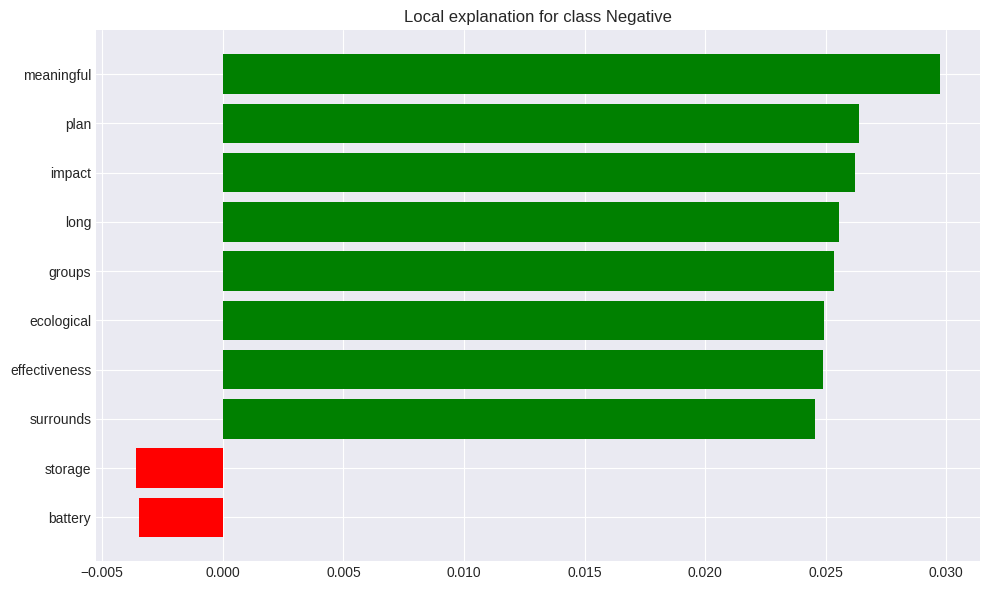

In [21]:
fig = lime_explainer.plot_explanation(exp, label=y_pred_lr[sample_idx], figsize=(10, 6))
plt.savefig('../results/figures/lime_explanation_sample1.png', dpi=300, bbox_inches='tight')
plt.show()

Sample Text (truncated):
annual report aviation trends indicates modest changes emission levels across europe countries show progress reducing greenhouse gases others struggle industrial growth energy demands data suggests varied approaches environmental policy differing outcomes...

True Label: Neutral
Predicted Label: Neutral


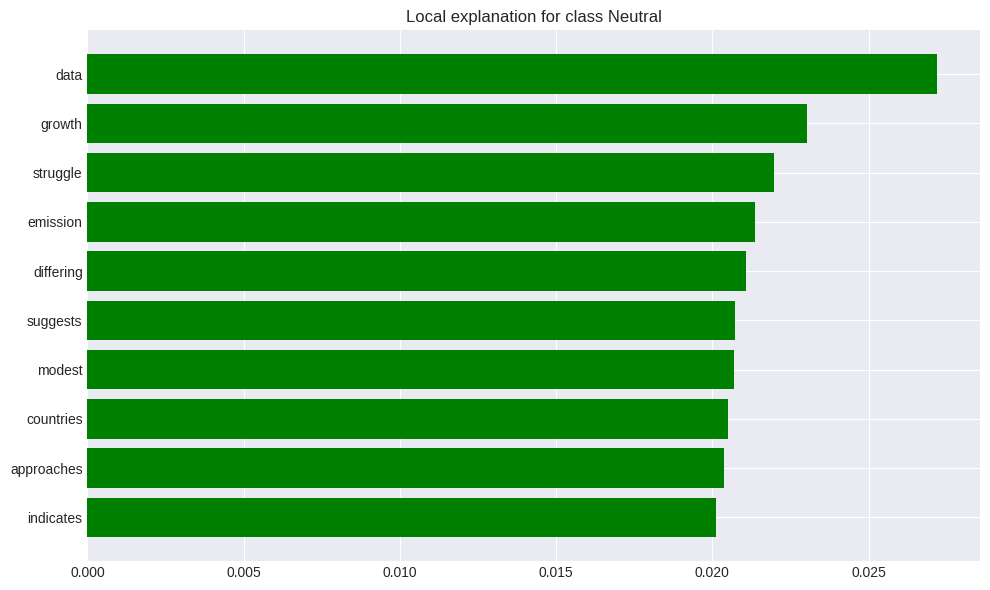

In [22]:
sample_idx = 50
sample_text = X_test.iloc[sample_idx]
true_label = le.classes_[y_test[sample_idx]]
pred_label = le.classes_[y_pred_lr[sample_idx]]

print(f"Sample Text (truncated):\n{sample_text[:300]}...\n")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")

exp2 = lime_explainer.explain_instance(sample_text, predict_fn, num_features=10, top_labels=1)
fig = lime_explainer.plot_explanation(exp2, label=y_pred_lr[sample_idx], figsize=(10, 6))
plt.savefig('../results/figures/lime_explanation_sample2.png', dpi=300, bbox_inches='tight')
plt.show()

### Analyze Multiple Predictions

In [23]:
print("Analyzing LIME explanations for multiple samples...\n")

for i, idx in enumerate([5, 20, 35], 1):
    sample_text = X_test.iloc[idx]
    true_label = le.classes_[y_test[idx]]
    pred_label = le.classes_[y_pred_lr[idx]]
    
    exp = lime_explainer.explain_instance(sample_text, predict_fn, num_features=5, top_labels=1)
    explanation_dict = exp.as_list(label=y_pred_lr[idx])
    
    print(f"Sample {i}:")
    print(f"  True: {true_label}, Predicted: {pred_label}")
    print(f"  Top contributing words:")
    for word, score in explanation_dict[:5]:
        print(f"    - {word}: {score:.4f}")
    print()

Analyzing LIME explanations for multiple samples...

Sample 1:
  True: Positive, Predicted: Positive
  Top contributing words:
    - sector: 0.0323
    - reduce: 0.0319
    - significantly: 0.0315
    - fuels: 0.0301
    - method: 0.0294

Sample 2:
  True: Negative, Predicted: Negative
  Top contributing words:
    - meaningful: 0.0354
    - effectiveness: 0.0346
    - surrounds: 0.0342
    - opposition: 0.0341
    - faced: 0.0334

Sample 3:
  True: Negative, Predicted: Negative
  Top contributing words:
    - health: 0.0489
    - calls: 0.0349
    - immediate: 0.0325
    - vulnerable: 0.0292
    - louder: 0.0276



## 7. Word Cloud Visualization

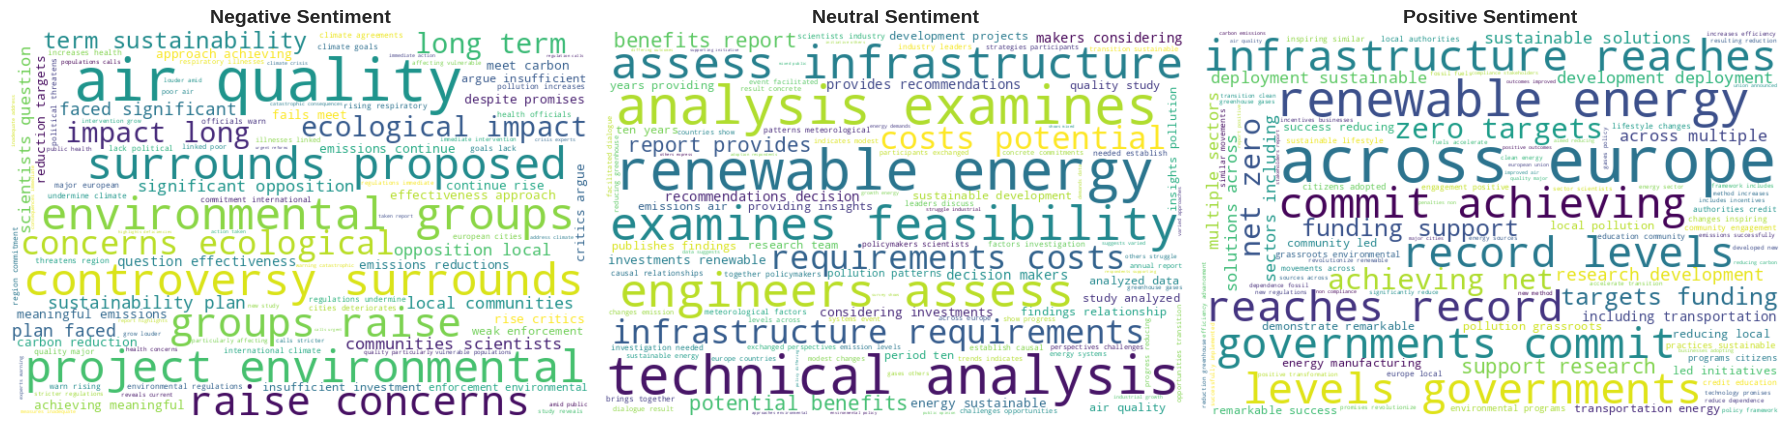

In [24]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, sentiment in enumerate(le.classes_):
    text_data = ' '.join(df[df['sentiment'] == sentiment]['text_clean'].astype(str))
    
    wordcloud = WordCloud(
        width=600, height=400, 
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text_data)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment} Sentiment', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/wordclouds_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Results

In [25]:
results_summary = {
    'logistic_regression': {
        'accuracy': float(metrics_lr['accuracy']),
        'precision': float(metrics_lr['precision']),
        'recall': float(metrics_lr['recall']),
        'f1_score': float(metrics_lr['f1_score']),
        'cohen_kappa': float(metrics_lr['cohen_kappa']),
        'matthews_corrcoef': float(metrics_lr['matthews_corrcoef'])
    },
    'svm': {
        'accuracy': float(metrics_svm['accuracy']),
        'precision': float(metrics_svm['precision']),
        'recall': float(metrics_svm['recall']),
        'f1_score': float(metrics_svm['f1_score']),
        'cohen_kappa': float(metrics_svm['cohen_kappa']),
        'matthews_corrcoef': float(metrics_svm['matthews_corrcoef'])
    }
}

import json
with open('../results/metrics/student2_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to ../results/metrics/student2_results.json")

import pickle
with open('../results/models_student2.pkl', 'wb') as f:
    pickle.dump({'lr': lr_model, 'svm': svm_model, 'vectorizer': vectorizer, 'label_encoder': le}, f)

print("✓ Models saved to ../results/models_student2.pkl")

✓ Results saved to ../results/metrics/student2_results.json
✓ Models saved to ../results/models_student2.pkl


## 9. Summary

In [26]:
print("="*60)
print("STUDENT 2 ANALYSIS SUMMARY")
print("="*60)
print("\nMETHODS APPLIED:")
print("1. TF-IDF + Logistic Regression")
print("2. TF-IDF + SVM")
print("3. LIME Text Interpretability")
print("\nKEY FINDINGS:")
print(f"- Best Model: {'Logistic Regression' if metrics_lr['f1_score'] > metrics_svm['f1_score'] else 'SVM'}")
print(f"- Best F1-Score: {max(metrics_lr['f1_score'], metrics_svm['f1_score']):.4f}")
print(f"- Best Accuracy: {max(metrics_lr['accuracy'], metrics_svm['accuracy']):.4f}")
print(f"- TF-IDF Features: {X_train_tfidf.shape[1]}")
print("\n- LIME provides interpretable explanations for text predictions")
print("- Word clouds reveal distinct vocabulary patterns per sentiment")
print("\n" + "="*60)

STUDENT 2 ANALYSIS SUMMARY

METHODS APPLIED:
1. TF-IDF + Logistic Regression
2. TF-IDF + SVM
3. LIME Text Interpretability

KEY FINDINGS:
- Best Model: SVM
- Best F1-Score: 1.0000
- Best Accuracy: 1.0000
- TF-IDF Features: 1223

- LIME provides interpretable explanations for text predictions
- Word clouds reveal distinct vocabulary patterns per sentiment

